In [1]:
import cv2
import numpy as np
import pynq_dpu
import matplotlib.pyplot as plt
import scipy.ndimage
import time
import os
import cv2
from IPython.display import display, Image
import ipywidgets as widgets
from IPython.display import clear_output
from scipy.spatial.transform import Rotation as R
from scipy.special import softmax
from tqdm import tqdm
from pathlib import Path
from os import path as osp
from glob import glob

# Image preprocessing

In [2]:
image_size = (640, 480)
def softmax_numpy(x: np.ndarray, axis=1):
    x_max = np.max(x, axis=axis, keepdims=True)
    e_x = np.exp(x - x_max)
    return e_x / np.sum(e_x, axis=axis, keepdims=True)

def get_power():
    with os.popen("xmutil xlnx_platformstats | grep 'SOM total power'") as f:
        return int(f.read().split(":")[1].strip().split()[0])  # w mW
def preprocess_image(img_file, img_size):
    # Wczytanie obrazu
    img = cv2.imread(img_file, cv2.IMREAD_COLOR)
    if img is None:
        print(f"Nie udało się wczytać obrazu: {img_file}")
        return None
    # Zmiana rozmiaru obrazu
    img = cv2.resize(img, img_size)
    # Konwersja obrazu na odcienie szarości i normalizacja
    img_preprocessed = img.mean(-1) / 255
    # Konwersja obrazu z BGR na RGB
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    # Wyświetlenie obrazu
 #   plt.imshow(img_rgb)
 #   plt.axis('off')  # Ukrycie osi
 #   plt.show()
 #   print(f"Obraz {img_file} został przetworzony i wyświetlony.")
    return img_preprocessed

# Run model on DPU

In [ ]:
class NetworkDPU:
    
    def __init__(self, xmodel_path: str = 'MiniResNet_qu.xmodel', dpu_path: str = 'dpu.bit'):
        self.ov: pynq_dpu.DpuOverlay = pynq_dpu.DpuOverlay(dpu_path, download=True)
        self.ov.load_model(xmodel_path)
        self.dpu = self.ov.runner
        print(self.ov.runner)
        inputTensors = self.dpu.get_input_tensors()
        outputTensors = self.dpu.get_output_tensors()
        # get list of shapes
        shapeIn = np.array([it.dims for it in inputTensors])
        shapeOut = np.array([ot.dims for ot in outputTensors])
        self.shapeIn = shapeIn
        self.shapeOut = shapeOut
        self.buff_in = [np.zeros(sh, np.int8, order='C') for sh in shapeIn]
        self.buff_out = [np.zeros(sh, np.int8, order='C') for sh in shapeOut]
        self.input_repr = [(it.get_attr('bit_width'), it.get_attr('fix_point')) for it in inputTensors]
        self.output_repr = [(ot.get_attr('bit_width'), ot.get_attr('fix_point')) for ot in outputTensors]
        print(inputTensors[0].dims)    # list of input tensor metadata
        print(outputTensors[0].dims)   # list of output tensor metadata
    def input_float_to_int8(self, x: np.ndarray) -> np.ndarray:
        BIT_WIDTH, PRECISION_BITS = self.input_repr[0]
        x = x * (2**PRECISION_BITS)
        x = np.floor(x)
        x = np.clip(x,-128, 127)
        return x.astype(np.int8)
    
    def output_int8_to_float(self, y: np.ndarray):
        BIT_WIDTH, PRECISION_BITS = self.output_repr[0]
        PRECISION = 1 / 2**PRECISION_BITS
        y = y * PRECISION
        return y.astype(np.float32)
    
    def output_int8_to_float_2(self, y: np.ndarray):
        BIT_WIDTH, PRECISION_BITS = self.output_repr[1]
        PRECISION = 1 / 2**PRECISION_BITS
        y = y * PRECISION
        return y.astype(np.float32)
    
    def input_float_to_int4(self, x: np.ndarray) -> np.ndarray:
        BIT_WIDTH, PRECISION_BITS = self.input_repr[0]
        print("INPUT BIT_WIDTH:", BIT_WIDTH)

        x = x * (2**PRECISION_BITS)
        x = np.floor(x)
        x = np.clip(x, -8, 7)  # int4 signed
        return x.astype(np.int8)
    
    def output_int4_to_float(self, y: np.ndarray):
        BIT_WIDTH, PRECISION_BITS = self.output_repr[0]
        PRECISION = 1 / 2**PRECISION_BITS
        y = y.astype(np.int8) 
        y = y * PRECISION
        return y.astype(np.float32)
    
    def output_int4_to_float_2(self, y: np.ndarray):
        BIT_WIDTH, PRECISION_BITS = self.output_repr[1]
        PRECISION = 1 / 2**PRECISION_BITS
        y = y.astype(np.int8) 
        y = y * PRECISION
        return y.astype(np.float32)
    
    def process(self, x: np.ndarray):
        time5 = time.perf_counter()
        x = self.input_float_to_int8(x)
        self.buff_in[0] = x
        # start DPU threat

        job_id = self.dpu.execute_async(self.buff_in, self.buff_out)
        self.dpu.wait(job_id)
        scores = self.buff_out[1]
        scores = self.output_int8_to_float_2(scores)
        descriptors_dense = self.buff_out[0]

        descriptors_dense = self.output_int8_to_float(descriptors_dense)
        time6 = time.perf_counter()

      #  scores = softmax_numpy(scores)
        time7 = time.perf_counter()
        scores = scores[:, :, :, :-1]
        b, h, w, _ = scores.shape
        scores = scores.reshape(b, h, w, 8, 8)
        scores = scores.transpose(0, 1, 3, 2, 4).reshape(b, h * 8, w * 8)
        return scores, descriptors_dense, time7-time5, time7-time6
    
    def __call__(self, x: np.ndarray):
        return self.process(x)

# Post processing

In [ ]:
def sample_descriptors(keypoints, descriptors, s: int = 8):
    """
    Samples and interpolates local descriptors at the given keypoint locations.

    The function maps the keypoints to normalized coordinates, then samples the descriptor
    map using bilinear interpolation (via scipy.ndimage.map_coordinates). The resulting
    descriptors are L2-normalized.

    Args:
        keypoints (np.ndarray): Array of shape (N, 2) containing keypoint coordinates (x, y)
                                in pixel units relative to the full-resolution image.
        descriptors (np.ndarray): Dense descriptor map of shape (H, W, C) where H and W are
                                  spatial dimensions, and C is the descriptor dimension.
        s (int, optional): Stride (downsampling factor) of the descriptor map compared to
                           the original image resolution. Default is 8.

    Returns:
        np.ndarray: Interpolated and L2-normalized descriptors of shape (N, C), where N is
                    the number of keypoints and C is the descriptor dimension.
    """
    h, w, c = descriptors.shape
    keypoints = (keypoints + 0.5) / (np.array([w, h]) * s)
    keypoints = keypoints * 2 - 1

    num_keypoints = keypoints.shape[0]
    sampled_descriptors = np.zeros((num_keypoints, c), dtype=descriptors.dtype)
    x = ((keypoints[:, 0] + 1) / 2) * (w - 1)
    y = ((keypoints[:, 1] + 1) / 2) * (h - 1)
    for ch in range(c):
        sampled_descriptors[:, ch] = scipy.ndimage.map_coordinates(
            descriptors[:,:,ch], [[y], [x]], order=1, mode='nearest')

    norms = np.linalg.norm(sampled_descriptors, axis=1, keepdims=True)
    descriptors_normalized = sampled_descriptors / (norms + 1e-6)
    return descriptors_normalized

def nms(scores, nms_radius: int):  
    assert nms_radius >= 0

    def max_pool(x, size):
        return scipy.ndimage.maximum_filter(x, size=size, mode='constant', cval=0.0)

    max_mask = scores == max_pool(scores, nms_radius * 2 + 1)
    suppressed_scores = np.where(max_mask, scores, 0)
    return suppressed_scores

def post_processing(scores, descriptors_dense, nms_radius=5, score_threshold=0.005, s=8):
    """
    Applies non-maximum suppression (NMS), thresholding, and descriptor sampling
    to extract keypoints and their descriptors from score and descriptor maps.

    Args:
        scores (np.ndarray): Keypoint score map (H, W).
        descriptors_dense (np.ndarray): Dense descriptor map (C, H, W).
        nms_radius (int): Radius for NMS filtering.
        score_threshold (float): Minimum score to keep a keypoint.
        s (int): Output stride of the network (e.g., 8).

    Returns:
        keypoints (np.ndarray): Detected keypoints (N, 2).
        descriptors (np.ndarray): Corresponding descriptors (N, C).
    """
    scores = nms(scores, nms_radius)
    pad = 4
    scores[:pad] = -1
    scores[:, :pad] = -1
    scores[-pad:] = -1
    scores[:, -pad:] = -1
    idxs = np.where(scores > score_threshold)
    keypoints = np.stack(idxs[::-1], axis=-1).astype(float)
    scores_all = scores[idxs]
    norms = np.linalg.norm(descriptors_dense, axis=0, keepdims=True)
    descriptors_dense = descriptors_dense / (norms + 1e-6)
    # for chosing only best keypoints (tested, but not used finally)
    indices = np.argsort(scores_all)[::-1]
    indices = indices[:300]
    keypoints_top = keypoints[indices]

    descriptors = sample_descriptors(keypoints, descriptors_dense, s)

    return keypoints, descriptors


# Maching

In [ ]:
def match_descriptors(kp1, desc1, kp2, desc2):
    # Match the keypoints with the warped_keypoints with nearest neighbor searc
    bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck=True)
    matches = bf.match(desc1, desc2)

    #matches = sorted(matches, key = lambda x:x.distance)
   # if len(matches) > 200:
   #     matches = matches[:200]
    matches_idx = np.array([m.queryIdx for m in matches])
    m_kp1 = [kp1[idx] for idx in matches_idx]
    matches_idx = np.array([m.trainIdx for m in matches])
    m_kp2 = [kp2[idx] for idx in matches_idx]
    return m_kp1, m_kp2, matches

def compute_homography(matched_kp1, matched_kp2):
    matched_pts1 = cv2.KeyPoint_convert(matched_kp1)
    matched_pts2 = cv2.KeyPoint_convert(matched_kp2)

    # Estimate the homography between the matches using RANSAC
    H, inliers = cv2.findHomography(matched_pts1,
                                    matched_pts2,
                                    cv2.RANSAC)
    inliers = inliers.flatten()
    return H, inliers

def match_points(scores1, descriptors1, scores2, descriptors2):
    time1 = time.perf_counter()

    keypoints1 = [cv2.KeyPoint(float(p[0]), float(p[1]), 1) for p in scores1]
    keypoints2 = [cv2.KeyPoint(float(p[0]), float(p[1]), 1) for p in scores2]
    time2 = time.perf_counter()

    m_kp1, m_kp2, matches = match_descriptors(keypoints1, descriptors1, keypoints2, descriptors2)
    time3 = time.perf_counter()
    H, inliers = compute_homography(m_kp1, m_kp2)
    time4 = time.perf_counter()

    matches = np.array(matches)[inliers.astype(bool)].tolist()
    time5 = time.perf_counter()
    #print(f"Średnie czasy (ms): uno: {(time2-time1)*1000:.6f} | matchdesc: {(time3-time2)*1000:.6f} | homo: {(time4-time3)*1000:.6f} | last: {(time5-time4)*1000:.6f} | all: {(time5-time1)*1000:.6f}| matches: {len(matches)}")

    return matches, keypoints1, keypoints2

def match_points_evaluation(keypoints1, descriptors1, keypoints2, descriptors2):
    m_kp1, m_kp2, matches = match_descriptors(keypoints1, descriptors1, keypoints2, descriptors2)
    H, inliers = compute_homography(m_kp1, m_kp2)
    return np.mean(inliers)

# Estimate position

In [ ]:
def depth_estimation(past_depth, kp1, kp2, K, factor=5000):

    pts2d = []
    pts3d = []
    for p1, p2 in zip(kp1, kp2):
        u, v = p1
        d = past_depth[int(v), int(u)] / factor

        if d == 0:
            continue

        x = (u - K[0, 2]) * d / K[0, 0]
        y = (v - K[1, 2]) * d / K[1, 1]

        pts3d.append([x, y, d])
        pts2d.append(p2)

    pts3d = np.array(pts3d, dtype=np.float32).reshape(-1, 1, 3)
    pts2d = np.array(pts2d, dtype=np.float32).reshape(-1, 1, 2)

    return pts2d, pts3d

def pose_estimation(points1, points2, t_total, R_total, abs_scale, focal=525.0, pp=(319.5, 239.5)):
    """
    Estimates relative camera pose using the Essential matrix and updates the global pose.
    """
    E, mask = cv2.findEssentialMat(points2, points1, focal=focal, pp=pp, method=cv2.RANSAC, prob=0.999, threshold=1.0)
    
    mask_bool = mask.ravel().astype(bool)
    _, R_diff, t, _ = cv2.recoverPose(E, points2[mask_bool], points1[mask_bool], focal=focal, pp=pp)
    angles_change = R.from_matrix(R_diff).as_euler('zyx', degrees=True)
    if np.any(np.abs(angles_change) > 15):
        return R_total, t_total, 1, angles_change

    t_total_new = t_total + abs_scale * R_total.dot(t)
    R_total_new = R_total.dot(R_diff)

    return R_total_new, t_total_new, 0, angles_change

def pose_3d(points1, points2, t_total, R_total, K, past_depth):
    """ 
    Estimates pose using PnP with 2D–3D correspondences and updates the global pose.
    """
    pts2d, pts3d = depth_estimation(past_depth, points1, points2, K)

    success, rvec, tvec, inliers = cv2.solvePnPRansac(
        pts3d, pts2d, K, None
    )
    R_3d, _ = cv2.Rodrigues(rvec)

    R_rel = R_3d
    t_rel = tvec.reshape(3, 1)

    R_rel_inv = R_rel.T
    t_rel_inv = -R_rel_inv @ t_rel

    R_diff = R_rel_inv
    t = t_rel_inv

    abs_scale = 1

    angles_change = R.from_matrix(R_diff).as_euler('zyx', degrees=True)
    if np.any(np.abs(angles_change) > 15):
        return R_total, t_total, 1, angles_change

    t_total_new = t_total + abs_scale * R_total.dot(t)
    R_total_new = R_total.dot(R_diff)

    return R_total_new, t_total_new, 0, angles_change


# Trajectory tools

In [ ]:
def get_gt(start, end, file):
    """
    Read trajectory for TUM dataset
    """
    trajectory_gt_data = np.loadtxt(file + r"groundtruth.txt")
    gt_timestamps = trajectory_gt_data[:, 0]

    timestamps_img = []
    with open(file + r"rgb.txt") as f:
        for line in f:
            if line.startswith("#") or line.strip() == "":
                continue
            ts = float(line.strip().split()[0])
            timestamps_img.append(ts)

    timestamps_img = np.array(timestamps_img)
    time_array = timestamps_img[start:end]
    closest_gt_indices = np.abs(gt_timestamps[:, np.newaxis] - time_array).argmin(axis=0)
    matched_gt = trajectory_gt_data[closest_gt_indices]

    quaternions = matched_gt[:, 4:8] 
    gt_rot = R.from_quat(quaternions)
    gt_euler = gt_rot.as_euler('zyx', degrees=True)  # yaw, pitch, roll
    t = matched_gt[:, 1:4]
    return t, gt_euler, matched_gt[:,0]

def save_trajectory_with_euler(filename, positions, euler_angles):
    """
    Saves trajectory positions and Euler angles to a text file.
    """
    # Łączymy dane w jedną macierz: [x y z roll pitch yaw]
    data = np.hstack((positions, euler_angles))

    # Zapis do pliku z nagłówkiem
    header = "x y z roll pitch yaw"
    np.savetxt(filename, data, fmt="%.6f", delimiter=" ", header=header, comments='')

    print(f"Zapisano do pliku: {filename}")
    
def read_kitti_trajectory_with_angles(gt_path):
    translations = []
    angles = []

    with open(gt_path, 'r') as f:
        for line in f:
            values = list(map(float, line.strip().split()))
            if len(values) != 12:
                continue
            matrix = np.array(values).reshape(3, 4)
            t = matrix[:, 3]
            R_mat = matrix[:, :3]
            euler = R.from_matrix(R_mat).as_euler('zyx', degrees=True)

            translations.append(t)
            angles.append(euler)

    return np.array(translations), np.array(angles)

def save_trajectory(t, euler_angles, time_array, output_file):
    """
    Saves trajectory data to a TUM-style text file.
    """
    assert (
        t.shape[0] == euler_angles.shape[0]
    ), "Długość wektorów t i euler_angles musi być taka sama"

    rot = R.from_euler("zyx", euler_angles, degrees=True)
    quats = rot.as_quat()  # scipy: [x, y, z, w]

    output_data = np.hstack(
        (
            time_array.reshape(-1, 1),  
            t,  
            quats, 
        )
    )

    np.savetxt(output_file, output_data, fmt="%.4f")



# Ewaluation functions

In [ ]:
def get_paths(exper_name):
    """
    Return a list of paths to the outputs of the experiment.
    """
    return glob(osp.join(EXPER_PATH, 'outputs/{}/*.npz'.format(exper_name)))


def compute_tp_fp(data, remove_zero=1e-4, distance_thresh=2, simplified=False):
    """
    Compute the true and false positive rates.
    """
    # Read data
    gt = np.where(data['keypoint_map'])
    gt = np.stack([gt[0], gt[1]], axis=-1)
    n_gt = len(gt)
    prob = data['prob_nms'] if 'prob_nms' in data.files else data['prob']

    # Filter out predictions with near-zero probability
    mask = np.where(prob > remove_zero)
    prob = prob[mask]
    pred = np.array(mask).T

    # When several detections match the same ground truth point, only pick
    # the one with the highest score  (the others are false positive)
    sort_idx = np.argsort(prob)[::-1]
    prob = prob[sort_idx]
    pred = pred[sort_idx]

    diff = np.expand_dims(pred, axis=1) - np.expand_dims(gt, axis=0)
    dist = np.linalg.norm(diff, axis=-1)
    matches = np.less_equal(dist, distance_thresh)

    tp = []
    matched = np.zeros(len(gt))
    for m in matches:
        correct = np.any(m)
        if correct:
            gt_idx = np.argmax(m)
            tp.append(not matched[gt_idx])
            matched[gt_idx] = 1
        else:
            tp.append(False)
    tp = np.array(tp, bool)
    if simplified:
        tp = np.any(matches, axis=1)  # keeps multiple matches for the same gt point
        n_gt = np.sum(np.minimum(np.sum(matches, axis=0), 1))  # buggy
    fp = np.logical_not(tp)
    return tp, fp, prob, n_gt


def div0(a, b):
    with np.errstate(divide='ignore', invalid='ignore'):
        c = np.true_divide(a, b)
        idx = ~np.isfinite(c)
        c[idx] = np.where(a[idx] == 0, 1, 0)  # -inf inf NaN
    return c


def compute_pr(exper_name, **kwargs):
    """
    Compute precision and recall.
    """
    # Gather TP and FP for all files
    paths = get_paths(exper_name)
    tp, fp, prob, n_gt = [], [], [], 0
    for path in paths:
        t, f, p, n = compute_tp_fp(np.load(path), **kwargs)
        tp.append(t)
        fp.append(f)
        prob.append(p)
        n_gt += n
    tp = np.concatenate(tp)
    fp = np.concatenate(fp)
    prob = np.concatenate(prob)

    # Sort in descending order of confidence
    sort_idx = np.argsort(prob)[::-1]
    tp = tp[sort_idx]
    fp = fp[sort_idx]
    prob = prob[sort_idx]

    # Cumulative
    tp_cum = np.cumsum(tp)
    fp_cum = np.cumsum(fp)
    recall = div0(tp_cum, n_gt)
    precision = div0(tp_cum, tp_cum + fp_cum)
    recall = np.concatenate([[0], recall, [1]])
    precision = np.concatenate([[0], precision, [0]])
    precision = np.maximum.accumulate(precision[::-1])[::-1]
    return precision, recall, prob


def compute_mAP(precision, recall):
    """
    Compute average precision.
    """
    return np.sum(precision[1:] * (recall[1:] - recall[:-1]))


def loc_error_per_image(pred, gt):

        diff = np.expand_dims(pred, axis=1) - np.expand_dims(gt, axis=0)
        dist = np.linalg.norm(diff, axis=-1)
        dist = np.min(dist, axis=1)
        correct_dist = dist[np.less_equal(dist, distance_thresh)]
        return correct_dist
    
def warp_keypoints(keypoints, H):
    """
    :param keypoints:
    points:
        numpy (N, (x,y))
    :param H:
    :return:
    """
    num_points = keypoints.shape[0]
    homogeneous_points = np.concatenate([keypoints, np.ones((num_points, 1))],
                                        axis=1)
    warped_points = np.dot(homogeneous_points, np.transpose(H))
    return warped_points[:, :2] / warped_points[:, 2:]

def compute_repeatability(keypoints, warped_keypoints, shape, H, keep_k_points=300,
                          distance_thresh=3, verbose=False):
    """
    Compute the repeatability. The experiment must contain in its output the prediction
    on 2 images, an original image and a warped version of it, plus the homography
    linking the 2 images.
    """

    def filter_keypoints(points, shape):
        """ Keep only the points whose coordinates are
        inside the dimensions of shape. """
        """
        points:
            numpy (N, (x,y))
        shape:
            (y, x)
        """
        mask = (points[:, 0] >= 0) & (points[:, 0] < shape[1]) &\
               (points[:, 1] >= 0) & (points[:, 1] < shape[0])
        print(mask.shape)
        return points[mask, :]

    def keep_true_keypoints(points, H, shape):
        """ Keep only the points whose warped coordinates by H
        are still inside shape. """
        """
        input:
            points: numpy (N, (x,y))
            shape: (y, x)
        return:
            points: numpy (N, (x,y))
        """
        # warped_points = warp_keypoints(points[:, [1, 0]], H)
        warped_points = warp_keypoints(points[:, [0, 1]], H)
        # warped_points[:, [0, 1]] = warped_points[:, [1, 0]]
        mask = (warped_points[:, 0] >= 0) & (warped_points[:, 0] < shape[1]) &\
               (warped_points[:, 1] >= 0) & (warped_points[:, 1] < shape[0])
        return points[mask, :]

    def select_k_best(points, k):
        """ Select the k most probable points (and strip their proba).
        points has shape (num_points, 3) where the last coordinate is the proba. """
        sorted_prob = points
        if points.shape[1] > 2:
            sorted_prob = points[points[:, 2].argsort(), :2]
            start = min(k, points.shape[0])
            sorted_prob = sorted_prob[-start:, :]
        return sorted_prob

    # paths = get_paths(exper_name)
    localization_err = -1
    repeatability = []
    N1s = []
    N2s = []
    # for path in paths:
    # data = np.load(path)


    # Filter out predictions
    # keypoints = np.where(data['prob'] > 0)
    # prob = data['prob'][keypoints[0], keypoints[1]]
    # keypoints = np.stack([keypoints[0], keypoints[1]], axis=-1)
    # warped_keypoints = np.where(data['warped_prob'] > 0)
    # warped_prob = data['warped_prob'][warped_keypoints[0], warped_keypoints[1]]
    # warped_keypoints = np.stack([warped_keypoints[0],
    #                              warped_keypoints[1],
    #                              warped_prob], axis=-1)
    # keypoints = data['prob'][:, :2]

    print(keypoints.shape)
    warped_keypoints = keep_true_keypoints(warped_keypoints, np.linalg.inv(H),
                                           shape)
    print(warped_keypoints.shape)

    # Warp the original keypoints with the true homography
    true_warped_keypoints = keypoints
    # true_warped_keypoints[:,:2] = warp_keypoints(keypoints[:, [1, 0]], H)
    true_warped_keypoints[:,:2] = warp_keypoints(keypoints[:, :2], H) # make sure the input fits the (x,y)
    # true_warped_keypoints = np.stack([true_warped_keypoints[:, 1],
    #                                   true_warped_keypoints[:, 0],
    #                                   prob], axis=-1)
    true_warped_keypoints = filter_keypoints(true_warped_keypoints, shape)

    # Keep only the keep_k_points best predictions
    #warped_keypoints = select_k_best(warped_keypoints, keep_k_points)
    #true_warped_keypoints = select_k_best(true_warped_keypoints, keep_k_points)

    # Compute the repeatability
    N1 = true_warped_keypoints.shape[0]
    N2 = warped_keypoints.shape[0]
    N1s.append(N1)
    N2s.append(N2)
    true_warped_keypoints = np.expand_dims(true_warped_keypoints, 1)
    warped_keypoints = np.expand_dims(warped_keypoints, 0)
    # shapes are broadcasted to N1 x N2 x 2:
    norm = np.linalg.norm(true_warped_keypoints - warped_keypoints,
                          ord=None, axis=2)
    count1 = 0
    count2 = 0
    local_err1, local_err2 = None, None
    if N2 != 0:
        min1 = np.min(norm, axis=1)
        count1 = np.sum(min1 <= distance_thresh)
        # print("count1: ", count1)
        local_err1 = min1[min1 <= distance_thresh]
        # print("local_err1: ", local_err1)
    if N1 != 0:
        min2 = np.min(norm, axis=0)
        count2 = np.sum(min2 <= distance_thresh)
        local_err2 = min2[min2 <= distance_thresh]

    if N1 + N2 > 0:
        # repeatability.append((count1 + count2) / (N1 + N2))
        repeatability = (count1 + count2) / (N1 + N2)
    if count1 + count2 > 0:
        localization_err = 0
        if local_err1 is not None:
            localization_err += (local_err1.sum())/ (count1 + count2)
        if local_err2 is not None:
            localization_err += (local_err2.sum())/ (count1 + count2)
    else:
        repeatability = 0
    if verbose:
        pass
    # return np.mean(repeatability)
    return repeatability, localization_err

# Test for 2 iamges from HPatches

In [10]:
img_file = "hpaches_all/i_ajuntament/1.ppm"
img_preprocessed = preprocess_image(img_file, image_size)

img_file = "hpaches_all/i_ajuntament/2.ppm"
img_preprocessed_2 = preprocess_image(img_file, image_size)

In [11]:
net = NetworkDPU(xmodel_path='SuperPointNet_soft_480.xmodel', 
                 dpu_path='dpu.bit')

vart::Runner@0xaaaacd43f700
[1, 480, 640, 1]
[1, 60, 80, 256]


In [12]:
start_time = time.perf_counter()

y_pred1 = net(img_preprocessed)
y_pred2 = net(img_preprocessed_2)

end_time = time.perf_counter()
execution_time = (end_time - start_time) * 1000 /2
print(f"Time: {execution_time:.6f} ms")

Time: 105.454373 ms


In [13]:
start_time = time.perf_counter()
print(y_pred1[0][0].shape)
scores1, descriptors1 = post_processing(y_pred1[0][0], y_pred1[1][0])
scores2, descriptors2 = post_processing(y_pred2[0][0], y_pred2[1][0])
end_time = time.perf_counter()
execution_time = (end_time - start_time) * 1000 / 2
print(f"Time: {execution_time:.6f} ms")

(480, 640)
Time: 162.218162 ms


In [14]:
start_time = time.perf_counter()
matches, k1, k2 = match_points(scores1, descriptors1, scores2, descriptors2)
print(len(k1))
end_time = time.perf_counter()
execution_time = (end_time - start_time) * 1000
print(f"Time: {execution_time:.6f} ms")

465
Time: 191.008394 ms


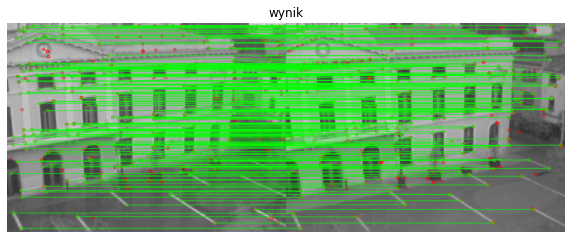

In [15]:
img1 = cv2.imread(f'hpaches_all/i_ajuntament/1.ppm', cv2.IMREAD_COLOR)
img1 = cv2.resize(img1, image_size)
img2 = cv2.imread(f'hpaches_all/i_ajuntament/2.ppm', cv2.IMREAD_COLOR)
img2 = cv2.resize(img2, image_size)
matched_img = cv2.drawMatches(img1, k1, img2, k2, matches,
                                    None, matchColor=(0, 255, 0),
                                    singlePointColor=(0, 0, 255))
matched_rgb = cv2.cvtColor(matched_img, cv2.COLOR_BGR2RGB)

# Wyświetlenie obrazu w Jupyter Notebook
plt.figure(figsize=(10, 5))
plt.imshow(matched_rgb)
plt.title("wynik")
plt.axis("off")  # Ukrycie osi
plt.show()

# Run odometry pipeline on KITTI or TUM

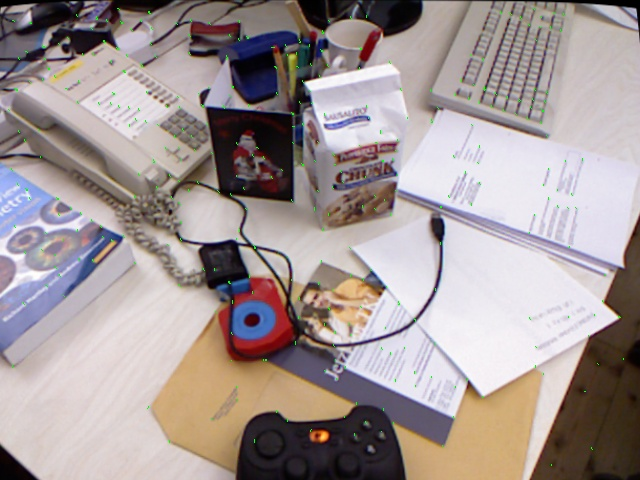

Średnie czasy (ms): pre: 119.759738 | net: 94.992760 | post: 0.001920 | matching: 56.600320 | pose: 12.328822 | all: 425.630958 | matches: 178.814070


In [ ]:
#For TUM
t_gt, gt_euler, time_array = get_gt(0, 200, 'desk/')
#For KITTI
#t_gt, gt_euler = read_kitti_trajectory_with_angles('00.txt')
start_t = t_gt[0]
t_start = np.array([[start_t[0]],
                    [start_t[1]],
                    [start_t[2]]])
# Rotacja z kwaternionu
r = R.from_euler("zyx",gt_euler[0],degrees=True)
start_R = r.as_matrix()
r = R.from_matrix(start_R)
angles = r.as_euler('zyx', degrees=True)  # yaw, pitch, roll
R_list = [angles]

total_t = np.zeros((3,1))
total_R = np.eye(3)
trajectory = [t_start.flatten().tolist()]

last_scores = None
last_descriptors = None
time4 = 0
pre_times = []
net_times = []
post_times = []
matching_times = []
pose_times = []
all_times = []
matches_list = []
matches = []
image_folder = 'desk'
image_files = sorted([f for f in os.listdir(image_folder) if f.endswith((".png", ".jpg", ".ppm"))])
depth_image_files = sorted(
            [
                f
                for f in os.listdir("depth_desk/")
                if f.endswith((".png", ".jpg", ".ppm"))
            ]
        )

first_image = cv2.imread(os.path.join(image_folder, image_files[0]))
scale_x = image_size[0] / first_image.shape[1]
scale_y = image_size[1] / first_image.shape[0]
#For TUM
fx=517.3
fy= 516.5
cx=318.6
cy=255.3

d_l = np.array([0.2624, -0.9531, -0.0054, 0.0026, 1.1633])
K_l = np.array([fx, 0.0, cx, 0.0, fy, cy, 0.0, 0.0, 1.0]).reshape(3, 3)
# For KITTI
#fx=707.0912
#fy=707.0912
#cx=601.8873
#cy=183.1104
fx = fx * scale_x
fy = fy * scale_x

cx = cx * scale_x
cy = cy * scale_y
K = np.array([fx, 0.0, cx, 0.0, fy, cy, 0.0, 0.0, 1.0]).reshape(3, 3)

end_idx = 200
k1=[]
past_depth = None
for i in range(0, end_idx):
    print(f"Processing: {i/end_idx * 100}%")

    image_file = image_files[i]
    image_path = os.path.join(image_folder, image_file)
    start_time = time.perf_counter()


    img = cv2.imread(image_path, cv2.IMREAD_COLOR)
    
    img = cv2.undistort(img, K_l, d_l)
    img = cv2.resize(img, (image_size[0] + 32, image_size[1] + 16))
    img = img[8:-8, 16:-16, :]
    #img = cv2.resize(img, image_size)
    depth_image = cv2.imread(
    os.path.join("depth_desk/", depth_image_files[i]),
    cv2.IMREAD_UNCHANGED,
    )
    
    img_preprocessed = img.mean(-1) / 255
    time1 = time.perf_counter()

    y_pred = net(img_preprocessed)
    time2 = time.perf_counter()
    time_net = y_pred[2]
    scores, descriptors = post_processing(y_pred[0][0], y_pred[1][0])
    time3 = time.perf_counter()
    end = time.perf_counter()
    
    if last_descriptors is not None:
        matches, k1, k2 = match_points(scores, descriptors, last_scores, last_descriptors)

        for match in matches:
            pt1 = tuple(map(int, k1[match.queryIdx].pt))
            pt2 = tuple(map(int, k2[match.trainIdx].pt))
            cv2.arrowedLine(img, pt2, pt1, (0, 255, 0), 1, tipLength=0.2)
        end = time.perf_counter()
        pts1 = np.float32([k1[match.queryIdx].pt for match in matches])  # shape (N, 2)
        pts2 = np.float32([k2[match.trainIdx].pt for match in matches])  # shape (N, 2)

        #pose estimation
        abs_scale = np.linalg.norm(t_gt[i] - t_gt[i-1])

      #  total_R, total_t, result, R_diff = pose_estimation(pts2, pts1, total_t, total_R, abs_scale,focal=fx, pp=(cx, cy))
        total_R, total_t, result, R_diff = pose_3d(pts2, pts1, total_t, total_R, K, past_depth)

        r_global = start_R.dot(total_R)
        r = R.from_matrix(r_global)
        angles = r.as_euler('zyx', degrees=True)  # yaw, pitch, roll
        R_list.append(angles)
        trac = start_R.dot(total_t) + t_start
        trajectory.append(trac.flatten().tolist())
    end_time = time.perf_counter()

    last_descriptors = descriptors
    last_scores = scores
    past_depth = depth_image
    clear_output(wait=True)
    display(Image(data=cv2.imencode('.jpg', img)[1].tobytes()))
    execution_time = (end_time - start_time)
    pre_times.append(time1 - start_time)
    net_times.append(time_net)
    post_times.append(y_pred[3])
    matching_times.append(end - time3)
    pose_times.append(end_time - end)
    all_times.append(execution_time)
    matches_list.append(len(matches))

#save_trajectory_with_euler('tum_soft.txt', trajectory, R_list)
save_trajectory(
    np.array(trajectory),
    np.array(R_list),
    np.array(time_array),
    'tum_not_soft.txt',
)
num_iterations = len(pre_times) - 1
avg_pre = sum(pre_times[1:]) / num_iterations * 1000
avg_net = sum(net_times[1:]) / num_iterations * 1000
avg_post = sum(post_times[1:]) / num_iterations * 1000
avg_matching = sum(matching_times[1:]) / num_iterations * 1000
avg_pose = sum(pose_times[1:]) / num_iterations * 1000
avg_all = sum(all_times[1:]) / num_iterations * 1000
avg_matches = sum(matches_list[1:]) / num_iterations


print(f"Avg times (ms): pre: {avg_pre:.6f} | net: {avg_net:.6f} | post: {avg_post:.6f} | matching: {avg_matching:.6f} | pose: {avg_pose:.6f} | all: {avg_all:.6f} | matches: {avg_matches:.6f}")

# Plot trajectory

1240


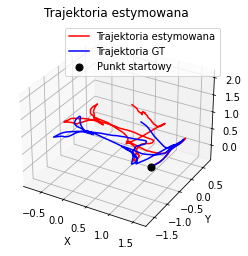

In [ ]:
#For TUM
t_gt, gt_euler, time_array = get_gt(0, 200, 'desk/')
#For KITTI
#t_gt, gt_euler = read_kitti_trajectory_with_angles('00.txt')
print(len(t_gt))
trajectory = np.array(trajectory)
t_gt = t_gt[:2000]
gt_euler = gt_euler[:2000]
tx_est, ty_est, tz_est = trajectory[:, 0], trajectory[:, 1], trajectory[:, 2]
tx, ty, tz = t_gt[:, 0], t_gt[:, 1], t_gt[:, 2]
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot(tx_est, ty_est, tz_est, label='Estimated trajectory', color='red')
ax.plot(tx, ty, tz, label='GT trajectory', color='blue')

ax.scatter(tx_est[0], ty_est[0], tz_est[0], color='black', marker='o', s=50, label='Start point')
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Z")
ax.set_title("Estimated trajectory")
x_limits = ax.get_xlim3d()
y_limits = ax.get_ylim3d()
z_limits = ax.get_zlim3d()

x_range = abs(x_limits[1] - x_limits[0])
y_range = abs(y_limits[1] - y_limits[0])
z_range = abs(z_limits[1] - z_limits[0])

max_range = max(x_range, y_range, z_range)

# wyśrodkuj osie
mid_x = np.mean(x_limits)
mid_y = np.mean(y_limits)
mid_z = np.mean(z_limits)

ax.set_xlim(mid_x - max_range/2, mid_x + max_range/2)
ax.set_ylim(mid_y - max_range/2, mid_y + max_range/2)
ax.set_zlim(mid_z - max_range/2, mid_z + max_range/2)
ax.legend()

plt.show()

# HPatches evaluation

In [ ]:
def warp_keypoints_2(keypoints, H):
    pts = np.array([kp.pt for kp in keypoints], dtype=np.float32)
    pts = np.expand_dims(pts, axis=1)
    warped_pts = cv2.perspectiveTransform(pts, H)
    return warped_pts[:, 0, :]

def scale_homography(H, old_shape, new_shape):
    """
    Scale homography H from old_shape (h, w) to new_shape.
    """
    h_old, w_old = old_shape
    h_new, w_new = new_shape

    sx = w_new / w_old
    sy = h_new / h_old

    S = np.array([
        [sx, 0, 0],
        [0, sy, 0],
        [0, 0, 1]
    ])
    S_inv = np.linalg.inv(S)

    H_scaled = S_inv @ H @ S
    return H_scaled

def compute_homography_accuracy(kp1, kp2, matches, H_gt, shape, correctness_thresh=3.0):
    if len(matches) < 4:
        return False

    pts1 = np.float32([kp1[m.queryIdx].pt for m in matches]).reshape(-1, 1, 2)
    pts2 = np.float32([kp2[m.trainIdx].pt for m in matches]).reshape(-1, 1, 2)

    H_pred, mask = cv2.findHomography(pts1, pts2, cv2.RANSAC)

    if H_pred is None:
        return False

    # Zamień narożniki obrazu przez H_gt i H_pred, porównaj przesunięcia
    corners = np.array([[0, 0, 1],
                            [0, shape[0] - 1, 1],
                            [shape[1] - 1, 0, 1],
                            [shape[1] - 1, shape[0] - 1, 1]])
    # corners = np.array([[0, 0, 1],
    #             [0, shape[1] - 1, 1],
    #             [shape[0] - 1, 0, 1],
    #             [shape[0] - 1, shape[1] - 1, 1]])
    real_warped_corners = np.dot(corners, np.transpose(H_gt))
    real_warped_corners = real_warped_corners[:, :2] / real_warped_corners[:, 2:]

    warped_corners = np.dot(corners, np.transpose(H_pred))
    warped_corners = warped_corners[:, :2] / warped_corners[:, 2:]

    mean_dist = np.mean(np.linalg.norm(real_warped_corners - warped_corners, axis=1))
    # correctness = float(mean_dist <= correctness_thresh)
    correctness = mean_dist <= correctness_thresh

    return correctness

def adjust_homography_for_crop(H, offset):
    """
    Zmodyfikuj homografię po wycięciu obrazu z przesunięciem offset = (x0, y0).
    """
    x0, y0 = offset
    T = np.array([
        [1, 0, -x0],
        [0, 1, -y0],
        [0, 0, 1]
    ])
    return H @ T

def crop_center(image, crop_width=640, crop_height=480):
    """
    Wytnij fragment o rozmiarze crop_width x crop_height ze środka obrazu.
    """
    h, w = image.shape[:2]

    # Upewnij się, że wycinek zmieści się w obrazie
    if crop_width > w or crop_height > h:
        raise ValueError("Rozmiar wycinka jest większy niż obraz")

    # Oblicz początkowy punkt wycinka (lewy górny róg)
    x0 = (w - crop_width) // 2
    y0 = (h - crop_height) // 2

    cropped = image[y0:y0+crop_height, x0:x0+crop_width]
    return cropped, (x0, y0)  # zwracamy też offset


def compute_repeatability_and_localization_error(kp1, kp2, shape, H, threshold=3):
    warped_kp1 = warp_keypoints_2(kp1, H)
    pts2 = np.array([kp.pt for kp in kp2], dtype=np.float32)
    h, w = shape

    valid = (
        (warped_kp1[:, 0] >= 0) & (warped_kp1[:, 0] < w) &
        (warped_kp1[:, 1] >= 0) & (warped_kp1[:, 1] < h)
    )
    warped_kp1 = warped_kp1[valid]

    if len(warped_kp1) == 0 or len(pts2) == 0:
        return 0.0, np.inf

    dists = np.linalg.norm(warped_kp1[:, np.newaxis, :] - pts2[np.newaxis, :, :], axis=2)
    min_dists = np.min(dists, axis=1)
    repeatable = np.sum(min_dists < threshold)
    repeatability = repeatable / len(kp1)

    loc_error = np.mean(min_dists[min_dists < threshold]) if repeatable > 0 else np.inf

    return repeatability, loc_error

def crop_matrix(offset):
    x0, y0 = offset
    return np.array([
        [1, 0, -x0],
        [0, 1, -y0],
        [0, 0, 1]
    ])

def evaluate_folder(folder_path):
    Repeatability = []
    Localization = []
    Homography = []

    image_size = (640, 480)
    path = os.path.join(folder_path, "1.ppm")
    img = cv2.imread(path, cv2.IMREAD_COLOR)
    if img is None:
        print(f"Corupted file: {path}")
        return None, None, None
    
    height, width = img.shape[:2]
    if width < 640 or height < 480:
        return None, None, None
    cropped_img, offset1 = crop_center(img)
    img_preprocessed = cropped_img.mean(-1) / 255
    y_pred1 = net(img_preprocessed)
    scores1, desc1 = post_processing(y_pred1[0][0], y_pred1[1][0])
    kp1 = [cv2.KeyPoint(float(p[0]), float(p[1]), 1) for p in scores1]
    print(len(kp1))
    for i in range(2, 7):
        img_i = os.path.join(folder_path, f"{i}.ppm")
        if i == 1:
            H = [[1, 0, 0], [0, 1, 0], [0, 0, 1]]
        else:
            H_path =  os.path.join(folder_path, f"H_1_{i}")
            H = np.loadtxt(H_path)

        img = cv2.imread(img_i, cv2.IMREAD_COLOR)
        if img is None:
            print(f"Corupted file: {path}")
            return None, None, None
        cropped_img_i, offset2 = crop_center(img)
        img_preprocessed = cropped_img_i.mean(-1) / 255
        y_pred_i = net(img_preprocessed)
        
        scores_i, desc_i = post_processing(y_pred_i[0][0], y_pred_i[1][0])
        kp_i = [cv2.KeyPoint(float(p[0]), float(p[1]), 1) for p in scores_i]
        T1 = crop_matrix(offset1)
        T2 = crop_matrix(offset2)
        H = T1 @ H @ np.linalg.inv(T2)
        print(type(scores_i))
        repeat, loc_err = compute_repeatability(scores1, scores_i, image_size, H)
        #repeat, loc_err = compute_repeatability_and_localization_error(kp1, kp_i, image_size, H)
        print(scores1)

        _,_,matches = match_descriptors(kp1, desc1, kp_i, desc_i)
        reproj = compute_homography_accuracy(kp1, kp_i, matches, H, image_size)
        print(f"{Path(folder_path).name} (1 <-> {i}):")
        print(f"  Repeatability: {repeat:.3f}")
        print(f"  Localization Error: {loc_err:.2f}")
        print(f"  Homography Estimation: {reproj:.2f}")
        if loc_err > 0:
            Localization.append(loc_err)
        else:
            Localization.append(3)

        Repeatability.append(repeat)
        Homography.append(reproj)
        
#        matched_img = cv2.drawMatches(cropped_img, kp1, cropped_img_i, kp_i, matches,
#                                    None, matchColor=(0, 255, 0),
#                                    singlePointColor=(0, 0, 255))
#        matched_rgb = cv2.cvtColor(matched_img, cv2.COLOR_BGR2RGB)

        # Wyświetlenie obrazu w Jupyter Notebook
#        plt.figure(figsize=(10, 5))
#        plt.imshow(matched_rgb)
#        plt.title("wynik")
#        plt.axis("off")  # Ukrycie osi
#        plt.show()
        
    return np.mean(Repeatability), np.mean(Localization), np.mean(Homography)

base_path = "hpaches_all/"
Repeatability_list = []
Localization_list = []
Homography_list = []
# Sprawdź każdy podfolder
for fname in os.listdir(base_path):
    folder_path = os.path.join(base_path, fname)
    Repeatability, Localization, Homography = evaluate_folder(folder_path)
    if Repeatability is not None:
        Repeatability_list.append(Repeatability)
        Localization_list.append(Localization)
        Homography_list.append(Homography)
    
print("------------------------------FINAL RESULTS----------------------------")
print(f"  Repeatability: {np.mean(Repeatability_list):.3f}")
print(f"  Localization Error: {np.mean(Localization_list):.2f}")
print(f"  Homography Estimation: {np.mean(Homography_list):.2f}")
